<a href="https://colab.research.google.com/github/the-moose-machine/medical/blob/master/WeekendStrokeMortality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#The Weekend Effect of Mortality in Stroke Patients
Developed at the Hack Aotearoa 2020 datathon.

#Methodology Summary

Platform: Google Colab
Language: Python
Packages: pandas, numpy, statsmodels, tableone, mimiciii
Algorithm: generalised linear model

Data: MIMIC-III tables: clinical, derived. Merged on 'subject_id', 'hadm_id', 'icustay_id'

Data Processing: 
Dropping values:
1. All rows with null values in the icu9_code field since only stroke patients were studied.
2. Patient ages >= 90

Data Size: 4,322 incidents for 3,729 individual patients

Grouping by
1. Days of the week: Weekdays and weekends
2. Day of admission to ICU
2. Day of admission to Hospital
2. Ethnicity: White, black and other
3. Home Discharge: Home or to other health providers
4. Survival Period: short term < 6 months or long term >6 months
5. Admission type: emergency (emergency and urgent) or elective
6. GCS values: Mild -> GCS 13-15, Moderate -> GCS 9-12 OR Severe -> GCS 3-8

Model: 
Generalised Linear Model
binomial classifiers
Adjusted for age, gender and type of admission, 

#Imports and Installations

In [0]:
# Data processing libraries
import pandas as pd
import numpy as np
import itertools

# Stats libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

# Image libraries
import matplotlib.pyplot as plt


# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
import os
from google.colab import auth
from google.cloud import bigquery

In [0]:
# install and import tableone
!pip install tableone
from tableone import TableOne

#MIMIC-III

##Connect to MIMIC-III

In [0]:
auth.authenticate_user()

In [0]:
# add your project ID for billing
project_id='hack-aotearoa'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

##Extract Data

In [0]:
# Run query and assign the results to a Pandas DataFrame
# Requires the icustay_detail view from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics
# And the OASIS score from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores
%%bigquery data

WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital, 
      i.dischtime dischtime_hospital, i.los_hospital, i.admission_age, i.admission_type, 
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu, 
      s.first_careunit
    FROM `physionet-data.mimiciii_derived.icustay_detail` i
    LEFT JOIN `physionet-data.mimiciii_clinical.icustays` s
    ON i.icustay_id = s.icustay_id
    WHERE i.hospstay_seq = 1
      AND i.icustay_seq = 1
      AND i.admission_age >= 16
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN `physionet-data.mimiciii_derived.oasis` o
ON f.icustay_id = o.icustay_id;

In [0]:
%%bigquery stroke_code

SELECT *
FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
WHERE ICD9_CODE like '433%' or icd9_CODE like '434%' or icd9_CODE like '430%' or icd9_CODE like '431%' or icd9_CODE like '432%'
;

In [0]:
%%bigquery patients

SELECT *
FROM `physionet-data.mimiciii_clinical.patients`;

In [0]:
%%bigquery admissions

SELECT *
FROM `physionet-data.mimiciii_clinical.admissions`;

In [0]:
%%bigquery gcsfirstday

SELECT *
FROM `physionet-data.mimiciii_derived.gcsfirstday`;

##Load data into a single DataFrame

In [0]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'icustay_expire_flag', 'oasis', 'oasis_prob'],
      dtype='object')

In [0]:
stroke_code.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [0]:
patients.columns

Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

In [0]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [0]:
gcsfirstday.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MinGCS', 'GCSMotor',
       'GCSVerbal', 'GCSEyes', 'EndoTrachFlag'],
      dtype='object')

In [0]:
#Rename columns to remove capitalization
stroke_code = stroke_code.rename(columns={'ROW_ID':'row_id', 'SUBJECT_ID':'subject_id', 'HADM_ID':'hadm_id', 'SEQ_NUM':'seq_num', 'ICD9_CODE':'icd9_code'})

patients = patients.rename(columns={'ROW_ID':'row_id', 'SUBJECT_ID':'subject_id', 'GENDER':'gender', 'DOB':'dob', 'DOD':'dod', 'DOD_HOSP':'dod_hosp', 'DOD_SSN':'dod_ssn', 'EXPIRE_FLAG':'expire_flag'})

admissions = admissions.rename(columns={'ROW_ID':'row_id', 'SUBJECT_ID':'subject_id', 'HADM_ID':'hadm_id', 'ADMITTIME':'admittime', 'DISCHTIME':'dischtime',
       'DEATHTIME':'deathtime', 'ADMISSION_TYPE':'admission_type', 'ADMISSION_LOCATION':'admission_location',
       'DISCHARGE_LOCATION':'discharge_location', 'INSURANCE':'insurance', 'LANGUAGE':'language', 'RELIGION':'religion',
       'MARITAL_STATUS':'marital_status', 'ETHNICITY':'ethnicity', 'EDREGTIME':'edregtime', 'EDOUTTIME':'edouttime', 'DIAGNOSIS':'diagnosis',
       'HOSPITAL_EXPIRE_FLAG':'hospital_expire_flag', 'HAS_CHARTEVENTS_DATA':'has_chartevents_data'})

gcsfirstday = gcsfirstday.rename(columns={'SUBJECT_ID':'subject_id', 'HADM_ID':'hadm_id', 'ICUSTAY_ID':'icustay_id', 'MinGCS':'mingcs', 'GCSMotor':'gcsmotor', 'GCSVerbal':'gcsverbal', 'GCSEyes':'gcseyes', 'EndoTrachFlag':'endotrachflag'})

In [0]:
stroke_code.columns, patients.columns, admissions.columns, gcsfirstday.columns

(Index(['row_id', 'subject_id', 'hadm_id', 'seq_num', 'icd9_code'], dtype='object'),
 Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
        'expire_flag'],
       dtype='object'),
 Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
        'deathtime', 'admission_type', 'admission_location',
        'discharge_location', 'insurance', 'language', 'religion',
        'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
        'hospital_expire_flag', 'has_chartevents_data'],
       dtype='object'),
 Index(['subject_id', 'hadm_id', 'icustay_id', 'mingcs', 'gcsmotor',
        'gcsverbal', 'gcseyes', 'endotrachflag'],
       dtype='object'))

In [0]:
data.shape, stroke_code.shape, admissions.shape, gcsfirstday.shape

((38558, 17), (5386, 5), (58976, 19), (61532, 8))

In [0]:
df = pd.merge(data, stroke_code, how='left', on=['subject_id', 'hadm_id'])

#Data Processing

##Dropping Null Values

In [0]:
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'icustay_expire_flag', 'oasis', 'oasis_prob',
       'row_id', 'seq_num', 'icd9_code'],
      dtype='object')

In [0]:
df.shape

(39187, 20)

In [0]:
#Check the various categories in icd9_code data
df.icd9_code.sort_values().unique()

array(['430', '431', '4320', '4321', '4329', '43300', '43301', '43310',
       '43311', '43320', '43321', '43330', '43331', '43380', '43381',
       '43391', '43400', '43401', '43410', '43411', '43490', '43491', nan],
      dtype=object)

These codes correspond to stroke patients

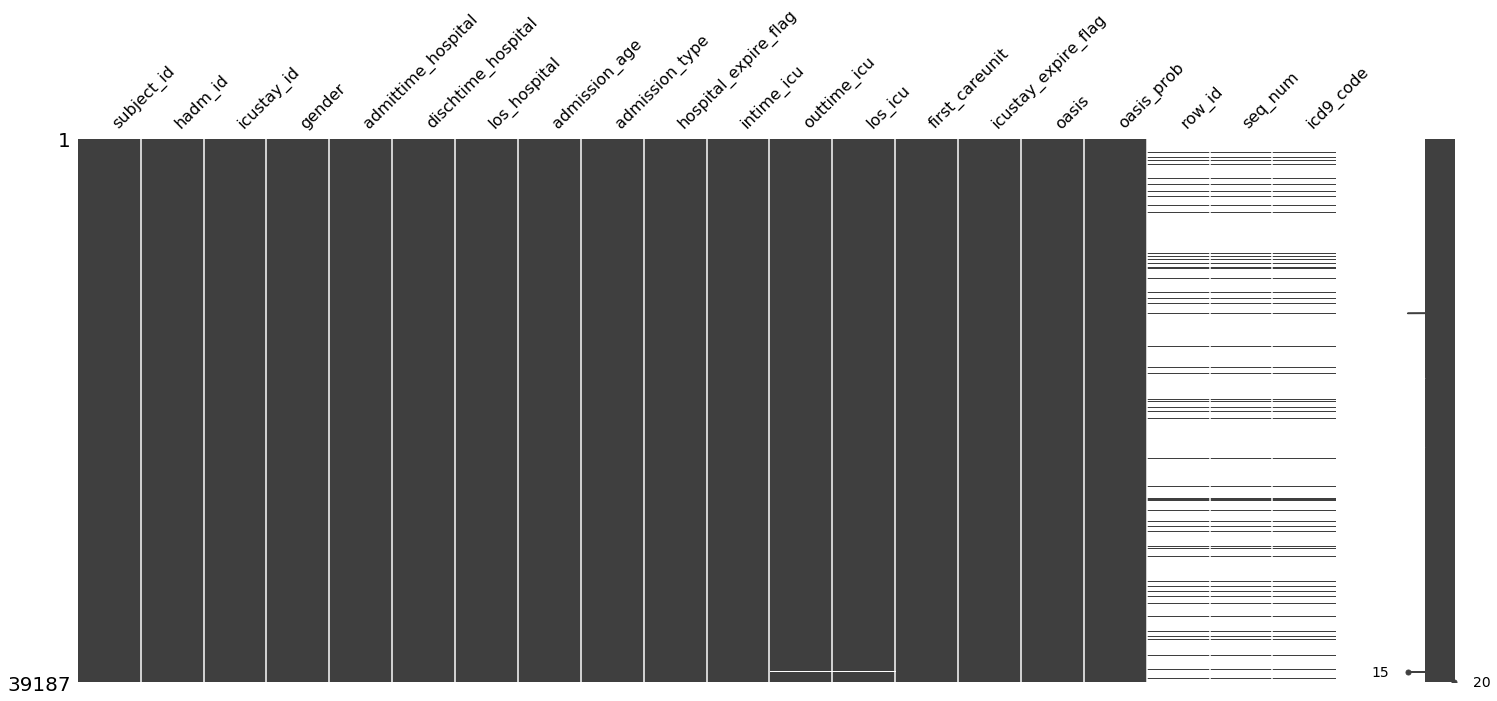

In [0]:
#Visualise the null values
import missingno as msno
msno.matrix(df)

Several null values are present in row_id, seq_num and icd9_code. Minimal null values are present in outcome_icu and los_icu

In [0]:
#Identify rows without NaN values
nonnan_rows_age = df[df['icd9_code'].isnotnull()]
nan_rows_age

In [0]:
#Drop the Null values of icd9_code
data = df.dropna(subset=['icd9_code'])

In [0]:
data.shape

(4585, 20)

Dropping the data without icd9_code values reduces the data frame from 39,187 to 4,585. It will be seen later that this corresponds to 3,729 individual patients. This indicates that some of the patients may have been admitted more than once.

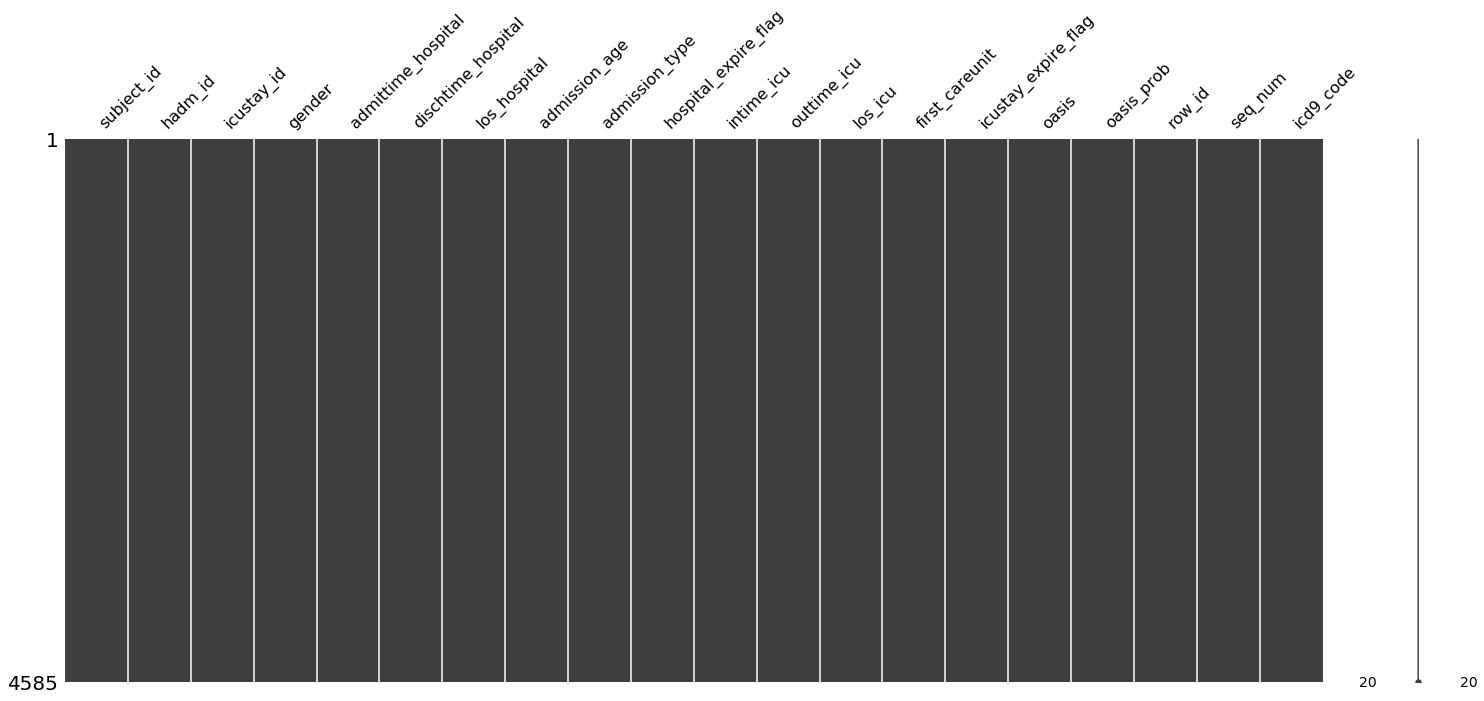

In [0]:
#Visualise the null values
msno.matrix(data)

All the null values have been taken care of.

##Dropping patients aged >= 90

In [0]:
data1 = data[data.admission_age < 300]
data1.shape

(4322, 20)

In [0]:
data.shape[0] - data1.shape[0]

263

Another 263 patients ($5.74\%$ of 4,585) have been removed.

##Merging the remaining DFs into a single DF

In [0]:
data2 = pd.merge(data1, patients, how='left', on=['subject_id'])
data1.shape, data2.shape

((4322, 20), (4322, 27))

In [0]:
data3 = pd.merge(data2, admissions, how='left', on=['subject_id', 'hadm_id'])
data1.shape, data2.shape, data3.shape

((4322, 20), (4322, 27), (4322, 44))

In [0]:
data4 = pd.merge(data3, gcsfirstday, how='left', on=['subject_id', 'hadm_id', 'icustay_id'])
data1.shape, data2.shape, data3.shape, data4.shape

((4322, 20), (4322, 27), (4322, 44), (4322, 49))

#Data Investigation

In [0]:
data4.head()

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0


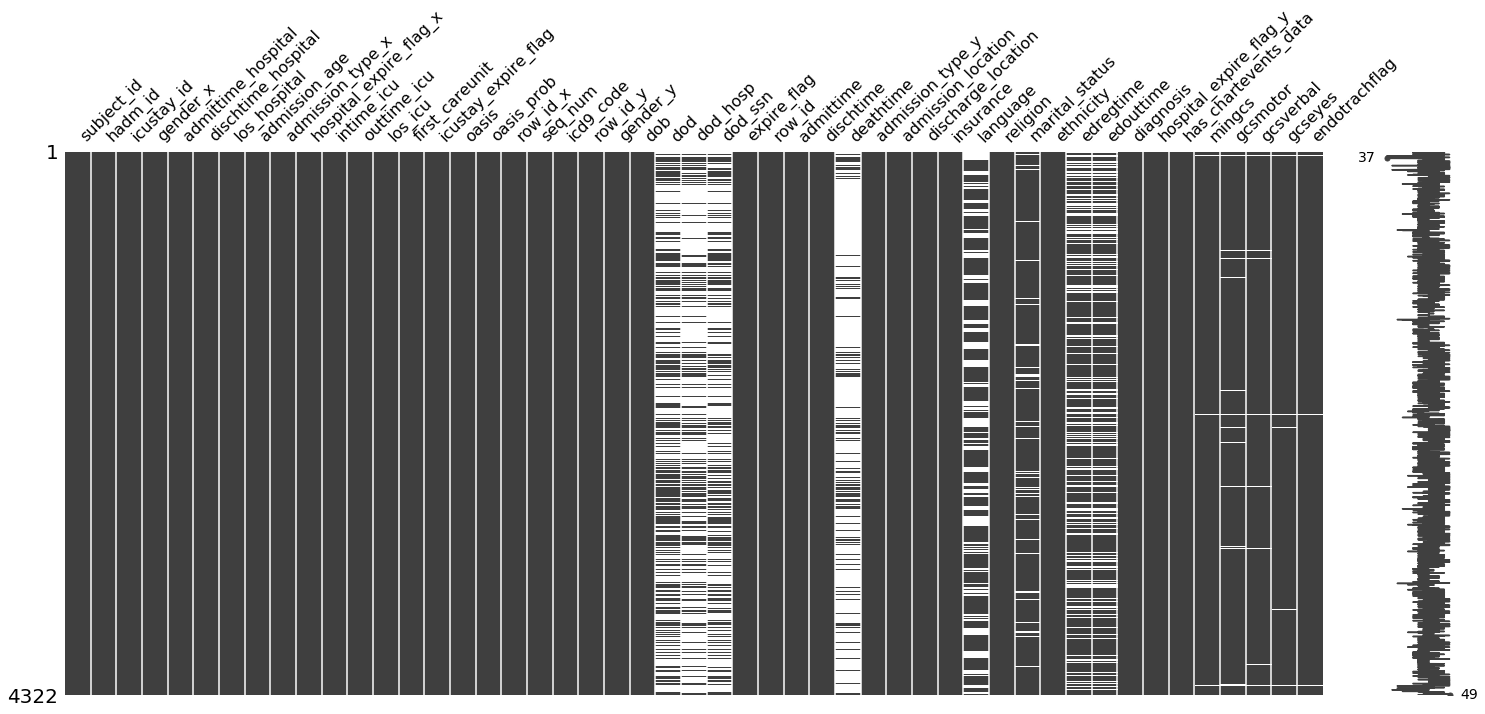

In [0]:
#Null values check
msno.matrix(data4)

In [0]:
data4.describe().Tfor col in data2:
   print(data2[col].value_counts(dropna=False))

,count,mean,std,min,25%,50%,75%,max
subject_id,4322.0,42513.549514,29486.926723,9.000000,17081.250000,31961.000000,67943.000000,99955.000000
hadm_id,4322.0,149316.867191,29130.372668,100018.000000,124250.500000,148846.000000,175432.000000,199972.000000
icustay_id,4322.0,250066.986812,29161.040441,200019.000000,224384.250000,249555.000000,275596.750000,299973.000000
los_hospital,4322.0,11.389634,11.624056,0.000000,4.000000,8.000000,15.000000,132.000000
admission_age,4322.0,66.950023,14.692192,17.000000,58.000000,69.000000,79.000000,89.000000
hospital_expire_flag_x,4322.0,0.212633,0.409218,0.000000,0.000000,0.000000,0.000000,1.000000
los_icu,4322.0,5.592781,7.232466,0.000000,1.000000,3.000000,7.000000,65.000000
icustay_expire_flag,4322.0,0.158723,0.365460,0.000000,0.000000,0.000000,0.000000,1.000000
oasis,4322.0,32.130264,8.738740,7.000000,26.000000,32.000000,38.000000,66.000000
oasis_prob,4322.0,0.154712,0.142329,0.005056,0.054187,0.109623,0.209226,0.903819


In [0]:
#Investigate contents to identify categorical and continuous data
for col in data2:
   print(data2[col].value_counts(dropna=False))

68764    5
89901    5
55689    4
93394    3
42894    3
        ..
56365    1
46120    1
19495    1
1062     1
32768    1
Name: subject_id, Length: 3729, dtype: int64
102932    5
122252    5
102419    4
146861    3
113932    3
         ..
181374    1
118999    1
171129    1
128120    1
114688    1
Name: hadm_id, Length: 3729, dtype: int64
290289    5
207844    5
219424    4
287584    3
213233    3
         ..
281930    1
219853    1
207563    1
283332    1
200126    1
Name: icustay_id, Length: 3729, dtype: int64
M    2347
F    1975
Name: gender_x, dtype: int64
2106-01-10 12:15:00    5
2179-10-13 13:15:00    5
2186-07-28 11:06:00    4
2154-09-01 19:02:00    3
2176-10-24 00:43:00    3
                      ..
2165-06-22 01:46:00    1
2104-12-29 16:21:00    1
2177-07-30 12:51:00    1
2131-04-07 13:10:00    1
2191-09-28 19:45:00    1
Name: admittime_hospital, Length: 3729, dtype: int64
2179-10-22 17:35:00    5
2106-01-16 15:50:00    5
2186-08-01 11:55:00    4
2125-01-29 20:25:00    3
2117-0

##Addition of Categorical Features

In [0]:
#Add columns for days of the week
data4['admitday_hospital'] = data4.admittime_hospital.dt.weekday_name
data4['dischday_hospital'] = data4.dischtime_hospital.dt.weekday_name
data4['inday_icu'] = data4.intime_icu.dt.weekday_name
data4['inday_icu_seq'] = data4.intime_icu.dt.weekday
data4['outday_icu'] = data4.outtime_icu.dt.weekday_name

In [0]:
data4['inday_icu'].value_counts()

Friday       712
Monday       690
Tuesday      657
Thursday     647
Wednesday    630
Sunday       514
Saturday     472
Name: inday_icu, dtype: int64

In [0]:
data4['inday_icu_wkd'] = np.where(data4.intime_icu.dt.weekday <= 4, 
                                 'weekday','weekend')
data4['inday_icu_wkd'].value_counts()

weekday    3336
weekend     986
Name: inday_icu_wkd, dtype: int64

#Table One

In [0]:
'admission_type_x' in data4.columns

True

In [0]:
#Table One
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit',
           'inday_icu_wkd']

groupby = 'inday_icu'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit','inday_icu_wkd']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu  ...             
                                              Missing  ...    Wednesday
n                                                      ...          630
gender_x               F                            0  ...   284 (45.1)
                       M                               ...   346 (54.9)
los_hospital                                        0  ...  11.9 (12.3)
admission_age                                       0  ...  67.4 (13.8)
admission_type_x       ELECTIVE                     0  ...    77 (12.2)
                       EMERGENCY                       ...   530 (84.1)
                       URGENT                          ...     23 (3.7)
hospital_expire_flag_x 0                            0  ...   508 (80.6)
                       1                               ...   122 (19.4)
los_icu                                             0  ...    5.5 (6.9)
icustay_expire_flag    0                            0  ...   539 (85.6)
                       1                               ...    91 (14.4)
oasis                                               0  ...   31.9 (8.7)
oasis_prob                                          0  ...    0.2 (0.1)
first_careunit         CCU                          0  ...    71 (11.3)
                       CSRU                            ...    91 (14.4)
                       MICU                            ...   115 (18.3)
                       SICU                            ...   248 (39.4)
                       TSICU                           ...   105 (16.7)
inday_icu_wkd          weekday                      0  ...  630 (100.0)
                       weekend                         ...             

[22 rows x 8 columns]

In [0]:
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                  Missing  ...      weekend
n                                                          ...          986
gender_x               F                                0  ...   454 (46.0)
                       M                                   ...   532 (54.0)
los_hospital                                            0  ...  11.2 (11.4)
admission_age                                           0  ...  65.8 (15.5)
admission_type_x       ELECTIVE                         0  ...     12 (1.2)
                       EMERGENCY                           ...   940 (95.3)
                       URGENT                              ...     34 (3.4)
hospital_expire_flag_x 0                                0  ...   721 (73.1)
                       1                                   ...   265 (26.9)
los_icu                                                 0  ...    5.8 (6.8)
icustay_expire_flag    0                                0  ...   795 (80.6)
                       1                                   ...   191 (19.4)
oasis                                                   0  ...   32.6 (8.5)
oasis_prob                                              0  ...    0.2 (0.1)
first_careunit         CCU                              0  ...     59 (6.0)
                       CSRU                                ...     46 (4.7)
                       MICU                                ...   188 (19.1)
                       SICU                                ...   526 (53.3)
                       TSICU                               ...   167 (16.9)

[20 rows x 3 columns]

#Plotting the data

In [0]:
# Pivot data to summarise by day
dat_dow = data4.groupby(['admission_type_x',
                        'inday_icu_seq'])['hospital_expire_flag_x'].mean().reset_index()

dat_dow = dat_dow.pivot(index='inday_icu_seq', 
                        columns='admission_type_x', values='hospital_expire_flag_x')

dat_dow

admission_type_x,ELECTIVE,EMERGENCY,URGENT
inday_icu_seq,,,
0,0.018182,0.205788,0.153846
1,0.037500,0.215929,0.416667
2,0.077922,0.211321,0.173913
3,0.014493,0.209220,0.285714
4,0.043478,0.221884,0.000000
5,0.000000,0.264901,0.416667
6,0.400000,0.271047,0.272727


Text(0, 0.5, 'Hospital mortality rate')

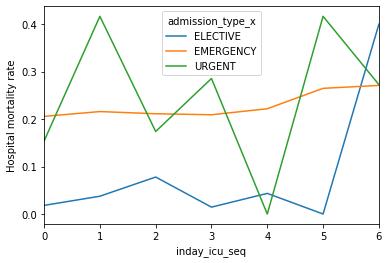

In [0]:
# day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ax = dat_dow.plot()
ax.set_ylabel("Hospital mortality rate")

Elective stroke patients indicate patients who have come from the operation theatre.

In [0]:
dat_wkd = data4.groupby(['admission_type_x','inday_icu_wkd'])['hospital_expire_flag_x'].mean().reset_index()
dat_wkd = dat_wkd.pivot(index='inday_icu_wkd', columns='admission_type_x', values='hospital_expire_flag_x')
dat_wkd.head()

admission_type_x,ELECTIVE,EMERGENCY,URGENT
inday_icu_wkd,,,
weekday,0.039755,0.212998,0.214286
weekend,0.166667,0.268085,0.323529


Text(0, 0.5, 'Hospital mortality rate')

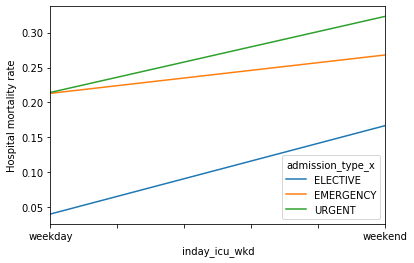

In [0]:
ax = dat_wkd.plot()
ax.set_ylabel("Hospital mortality rate")

#6-Month Mortality

Add a column indicating the number of days that the patient survived post-discharge.

##Inclusive of in-hospital mortality

In [0]:
data4['survival_time'] = data4['dod'].sub(data4['dischtime_hospital'], axis=0)

In [0]:
data4['death_post_discharge_in_days'] = np.where(data4.survival_time.dt.days <= 180, 'short_survival', 'long_survival')

In [0]:
#Turn it into a binary flag
d = {'short_survival': 1, 'long_survival': 0}
data4['survival_time_flag'] = data4['death_post_discharge_in_days'].map(d)

In [45]:
data4.head()

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency,1,0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency,1,1
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency,1,0


In [66]:
#Patients surviving over the short term (weekday ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

999

In [67]:
#Patients surviving over the short term (weekend ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

369

In [68]:
#Patients surviving over the long term (weekday ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

2337

In [69]:
#Patients surviving over the long term (weekend ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

617

## Creation of DF of Survivors
These are patients who were discharged alive.

In [46]:
#Check the type of discharge
data4['discharge_location'].value_counts(dropna=False)

REHAB/DISTINCT PART HOSP     1227
DEAD/EXPIRED                  919
HOME                          730
HOME HEALTH CARE              574
SNF                           465
LONG TERM CARE HOSPITAL       239
SHORT TERM HOSPITAL            68
DISC-TRAN CANCER/CHLDRN H      42
HOSPICE-MEDICAL FACILITY       28
HOSPICE-HOME                   18
LEFT AGAINST MEDICAL ADVI       6
DISCH-TRAN TO PSYCH HOSP        4
HOME WITH HOME IV PROVIDR       1
OTHER FACILITY                  1
Name: discharge_location, dtype: int64

In [16]:
#Create DF of only those who survived
df_survived = data4.where(data4.discharge_location.str.contains('DEAD') == False)
df_survived.discharge_location, data4.discharge_location

(0                            NaN
 1               HOME HEALTH CARE
 2                            NaN
 3                            NaN
 4       REHAB/DISTINCT PART HOSP
                   ...           
 4317            HOME HEALTH CARE
 4318                         NaN
 4319                         NaN
 4320                HOSPICE-HOME
 4321                         NaN
 Name: discharge_location, Length: 4322, dtype: object,
 0                   DEAD/EXPIRED
 1               HOME HEALTH CARE
 2                   DEAD/EXPIRED
 3                   DEAD/EXPIRED
 4       REHAB/DISTINCT PART HOSP
                   ...           
 4317            HOME HEALTH CARE
 4318                DEAD/EXPIRED
 4319                DEAD/EXPIRED
 4320                HOSPICE-HOME
 4321                DEAD/EXPIRED
 Name: discharge_location, Length: 4322, dtype: object)

In [17]:
#Drop the Null values of discharge_location in survivors DF
df_survived = df_survived.dropna(subset=['discharge_location'])
data4.shape, df_survived.shape

((4322, 62), (3403, 62))

The 919 patients (4,322 - 3,403) who were identified as 'DEAD/EXPIRED' have been dropped from the DF. This produces a cohort of 3,403 entries of patients who survived being admitted into the ICU and were discharged.

In [70]:
#Verify resulting DF
df_survived[['dischtime', 'dod','survival_time', 'death_post_discharge_in_days', 'survival_time_flag', 'discharge_location', 'home_discharge_bool', 'inday_icu_wkd']].head()

,dischtime,dod,survival_time,death_post_discharge_in_days,survival_time_flag,discharge_location,home_discharge_bool,inday_icu_wkd
1,2132-08-11 17:19:00,2136-11-11,1552 days 06:41:00,long_survival,0.0,HOME HEALTH CARE,1.0,weekday
4,2151-07-15 13:50:00,2151-09-10,56 days 10:10:00,short_survival,1.0,REHAB/DISTINCT PART HOSP,0.0,weekday
6,2138-03-06 14:00:00,NaT,NaT,long_survival,0.0,HOME,1.0,weekday
9,2191-05-12 15:00:00,2191-05-13,0 days 09:00:00,short_survival,1.0,SNF,0.0,weekday
11,2150-11-30 18:14:00,NaT,NaT,long_survival,0.0,HOME,1.0,weekday


##Exclusive of in-hospital mortality

In [61]:
#Patients surviving over the short term (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

345

In [62]:
#Patients surviving over the short term (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

104

In [63]:
#Patients surviving over the long term (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

2337

In [64]:
#Patients surviving over the long term (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

617

#Adding Ethnicity, Marital Status and Insurance Status

##Ethnicity

In [0]:
data4['ethnicity'].value_counts(dropna=False)

WHITE                                        3125
UNKNOWN/NOT SPECIFIED                         362
BLACK/AFRICAN AMERICAN                        273
HISPANIC OR LATINO                            123
OTHER                                         109
UNABLE TO OBTAIN                               83
ASIAN                                          77
PATIENT DECLINED TO ANSWER                     28
HISPANIC/LATINO - PUERTO RICAN                 16
ASIAN - CHINESE                                16
HISPANIC/LATINO - DOMINICAN                    15
MULTI RACE ETHNICITY                           10
WHITE - RUSSIAN                                 9
WHITE - BRAZILIAN                               8
BLACK/CAPE VERDEAN                              8
PORTUGUESE                                      7
WHITE - OTHER EUROPEAN                          7
BLACK/HAITIAN                                   7
ASIAN - ASIAN INDIAN                            5
HISPANIC/LATINO - GUATEMALAN                    4


Ethnicity will be categorised into BLACK, WHITE, OTHER and UNKNOWN. Run the code in the following box using the appropriate terminology.

In [0]:
#Investigate stats
#Here, calculating number of patients categorised as 'black' and admitted in the weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.ethnicity.str.contains('^BLACK'))]
df_filtered.shape[0]

65

##Marital Status

In [0]:
data4['marital_status'].value_counts(dropna=False)

MARRIED              2257
SINGLE                842
WIDOWED               585
NaN                   337
DIVORCED              236
UNKNOWN (DEFAULT)      38
SEPARATED              25
LIFE PARTNER            2
Name: marital_status, dtype: int64

In [0]:
#Investigate statistics
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.marital_status == 'MARRIED')]
df_filtered.shape[0]

1737

##Insurance

In [0]:
data4['insurance'].value_counts(dropna=False)

Medicare      2490
Private       1365
Medicaid       309
Government     102
Self Pay        56
Name: insurance, dtype: int64

In [0]:
#Investigate statistics
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.insurance == 'Medicaid')]
df_filtered.shape[0]

82

#GCS Values

In [0]:
data4['mingcs'].value_counts(dropna=False)

15.0    2140
14.0     727
13.0     288
3.0      164
12.0     154
11.0     152
10.0     135
7.0      125
9.0      115
6.0      111
8.0      106
4.0       43
NaN       31
5.0       31
Name: mingcs, dtype: int64

These are the standards prescribed by the British Medical Journal.

Mild -> GCS 13-15

Moderate -> GCS 9-12

Severe -> GCS 3-8

In [0]:
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit', 'mingcs']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                  Missing  ...      weekend
n                                                          ...          986
gender_x               F                                0  ...   454 (46.0)
                       M                                   ...   532 (54.0)
los_hospital                                            0  ...  11.2 (11.4)
admission_age                                           0  ...  65.8 (15.5)
admission_type_x       ELECTIVE                         0  ...     12 (1.2)
                       EMERGENCY                           ...   940 (95.3)
                       URGENT                              ...     34 (3.4)
hospital_expire_flag_x 0                                0  ...   721 (73.1)
                       1                                   ...   265 (26.9)
los_icu                                                 0  ...    5.8 (6.8)
icustay_expire_flag    0                                0  ...   795 (80.6)
                       1                                   ...   191 (19.4)
oasis                                                   0  ...   32.6 (8.5)
oasis_prob                                              0  ...    0.2 (0.1)
first_careunit         CCU                              0  ...     59 (6.0)
                       CSRU                                ...     46 (4.7)
                       MICU                                ...   188 (19.1)
                       SICU                                ...   526 (53.3)
                       TSICU                               ...   167 (16.9)
mingcs                                                 31  ...   12.6 (3.4)

[21 rows x 3 columns]

#Discharge Destination

##Inclusive of in-house mortality

In [0]:
data4['discharge_location'].value_counts(dropna=False)

REHAB/DISTINCT PART HOSP     1227
DEAD/EXPIRED                  919
HOME                          730
HOME HEALTH CARE              574
SNF                           465
LONG TERM CARE HOSPITAL       239
SHORT TERM HOSPITAL            68
DISC-TRAN CANCER/CHLDRN H      42
HOSPICE-MEDICAL FACILITY       28
HOSPICE-HOME                   18
LEFT AGAINST MEDICAL ADVI       6
DISCH-TRAN TO PSYCH HOSP        4
OTHER FACILITY                  1
HOME WITH HOME IV PROVIDR       1
Name: discharge_location, dtype: int64

In [0]:
#Identify all 'home' categories
home = ['HOME', 'HOME HEALTH CARE', 'HOME WITH HOME IV PROVIDR']
# The remaining are classified as 'other'

In [0]:
#Create a binary column with all 'home' categories as 1
data4['home_discharge_bool'] = data4.discharge_location.str.contains('^HOME')
data4.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender_x', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age',
       'admission_type_x', 'hospital_expire_flag_x', 'intime_icu',
       'outtime_icu', 'los_icu', 'first_careunit', 'icustay_expire_flag',
       'oasis', 'oasis_prob', 'row_id_x', 'seq_num', 'icd9_code', 'row_id_y',
       'gender_y', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type_y',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime',
       'diagnosis', 'hospital_expire_flag_y', 'has_chartevents_data', 'mingcs',
       'gcsmotor', 'gcsverbal', 'gcseyes', 'endotrachflag',
       'admitday_hospital', 'dischday_hospital', 'inday_icu', 'inday_icu_seq',
       'outday_icu', 'inday_icu_wkd', 'survival_time',
       'death_post_discharge_in_days', 'survival_time_flag',
     

In [0]:
data4.head(20)

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False
5,1054,183383,288218,M,2157-01-06 17:16:00,2157-01-08 15:00:00,2,79,EMERGENCY,1,2157-01-06 17:17:38,2157-01-07 22:01:06,1.0,SICU,0,51,0.581248,12291.0,1.0,430,998,M,2078-07-15,2157-01-08,2157-01-08,NaT,1,1310,2157-01-06 17:16:00,2157-01-08 15:00:00,2157-01-08 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,PROTESTANT QUAKER,MARRIED,WHITE,2157-01-06 14:49:00,2157-01-06 18:36:00,INTRACRANIAL HEMORRHAGE,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Saturday,Thursday,3,Friday,weekday,-1 days +09:00:00,short_survival,1,False
6,1253,129963,246324,F,2138-02-25 07:15:00,2138-03-06 14:00:00,9,58,ELECTIVE,0,2138-02-25 14:45:22,2138-02-26 21:39:17,1.0,SICU

In [41]:
#True=discharged for home - Weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.home_discharge_bool == True)] 
df_filtered.shape[0]

1051

In [42]:
#False=discharged for home - Weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.home_discharge_bool == True)] 
df_filtered.shape[0]

254

In [43]:
#True=discharged for other facilities - Weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.home_discharge_bool == False)] 
df_filtered.shape[0]

2285

In [44]:
#True=discharged for other facilities - Weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.home_discharge_bool == False)] 
df_filtered.shape[0]

732

In [0]:
#Excluding age>300
#For ICU mortality adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(admission_type_x) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Generalized linear model
===========================================================================================================
Model:              GLM                                                         AIC:            4961.6804  
Link Function:      logit                                                       BIC:            -31181.5994
Dependent Variable: ['home_discharge_bool[False]', 'home_discharge_bool[True]'] Log-Likelihood: -2474.8    
Date:               2020-01-21 01:51                                            LL-Null:        -2647.2    
No. Observations:   4322                                                        Deviance:       4949.7     
Df Model:           5                                                           Pearson chi2:   4.27e+03   
Df Residuals:       4316                                                        Scale:          1.0000     
Method:             IRLS                                                                                   
----------------------------------------------------------------------------------------------------------------
                                        Coef.       Std.Err.         z          P>|z|        [0.025       0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                              -2.6489        0.2066      -12.8240      0.0000      -3.0537      -2.2440
C(inday_icu_wkd)[T.weekend]             0.2485        0.0859        2.8920      0.0038       0.0801       0.4169
C(admission_type_x)[T.EMERGENCY]        1.2226        0.1191       10.2619      0.0000       0.9891       1.4561
C(admission_type_x)[T.URGENT]           0.9227        0.2422        3.8098      0.0001       0.4480       1.3974
C(gender_x)[T.M]                       -0.0908        0.0697       -1.3026      0.1927      -0.2275       0.0458
admission_age                           0.0362        0.0024       15.3572      0.0000       0.0316       0.0409
===========================================================================================================

"""

##Exclusive of in-house mortality
The statistics of only those who were discharged alive

In [31]:
#Verify resulting DF
df_survived[['discharge_location', 'home_discharge_bool', 'inday_icu_wkd']].head()

,discharge_location,home_discharge_bool,inday_icu_wkd
1,HOME HEALTH CARE,1.0,weekday
4,REHAB/DISTINCT PART HOSP,0.0,weekday
6,HOME,1.0,weekday
9,SNF,0.0,weekday
11,HOME,1.0,weekday


###Summary

In [40]:
#Surviving patients discharged for home (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.home_discharge_bool == True)] 
df_filtered.shape[0]

1051

In [37]:
#Surviving patients discharged for home (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.home_discharge_bool == True)] 
df_filtered.shape[0]

254

In [38]:
#Surviving patients discharged for other facilities (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.home_discharge_bool == False)] 
df_filtered.shape[0]

1631

In [39]:
#Surviving patients discharged for other facilities (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.home_discharge_bool == False)] 
df_filtered.shape[0]

467

#Grouping Emergency and Elective into one category

In [0]:
data4['admission_type_x'].value_counts(dropna=False)

EMERGENCY    3879
ELECTIVE      339
URGENT        104
Name: admission_type_x, dtype: int64

In [0]:
#admission_type_x
data4.admission_type_x.str.contains('EMERGENCY')

0       True
1       True
2       True
3       True
4       True
        ... 
4317    True
4318    True
4319    True
4320    True
4321    True
Name: admission_type_x, Length: 4322, dtype: bool

In [0]:
data4['adm_type_2'] = np.where(data4.admission_type_x == 'ELECTIVE', 'elective', 'emergency')
data4.head(20)

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency
5,1054,183383,288218,M,2157-01-06 17:16:00,2157-01-08 15:00:00,2,79,EMERGENCY,1,2157-01-06 17:17:38,2157-01-07 22:01:06,1.0,SICU,0,51,0.581248,12291.0,1.0,430,998,M,2078-07-15,2157-01-08,2157-01-08,NaT,1,1310,2157-01-06 17:16:00,2157-01-08 15:00:00,2157-01-08 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,PROTESTANT QUAKER,MARRIED,WHITE,2157-01-06 14:49:00,2157-01-06 18:36:00,INTRACRANIAL HEMORRHAGE,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Saturday,Thursday,3,Friday,weekday,-1 days +09:00:00,short_survival,1,False,emergency
6,1253,129963,246324,F,2138-02-25 07:15:00,2138-03-06 14

In [0]:
#Investigating statistics
df_filtered = data3[(data4.inday_icu_wkd == 'weekend') & (data4.adm_type_2 == 'emergency')] 
df_filtered.shape[0]

974

In [0]:
#Change 'adm_type_2' to boolean to run the model and predict on emergency
#Create a binary column with all 'home' categories as 1
data4['adm_type_2_bool'] = np.where(data4.adm_type_2 == 'emergency', 1, 0)

In [0]:
#home_discharge_bool
data4['home_discharge_flag'] = np.where(data4.home_discharge_bool == True, 1, 0)

#Statistical Analysis: T-Test

In [0]:
data4.head()

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency,1,0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency,1,1
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency,1,0


## GCS Scores
Comparing mingcs between weekend and weekday groups

In [0]:
#Retrieve a list of mingcs values for weekday and weekend patients
wkday_gcs = data4.mingcs.where(data4.inday_icu_wkd=='weekday')
wkend_gcs = data4.mingcs.where(data4.inday_icu_wkd=='weekend')
len(wkday_gcs), len(wkend_gcs), np.mean(wkday_gcs), np.mean(wkend_gcs)

(4322, 4322, 12.936009658919408, 12.554192229038854)

In [0]:
#T-test of 2 independent samples
scipy.stats.ttest_ind(wkday_gcs, wkend_gcs, nan_policy='omit')

Ttest_indResult(statistic=3.1576588971113297, pvalue=0.0016014522920464137)

##ICU Length of Stay
Comparing los_icu between weekend and weekday groups

In [0]:
#Retrieve a list of los_icu values for weekday and weekend patients
wkday_los_icu = data4.los_icu.where(data4.inday_icu_wkd=='weekday')
wkend_los_icu = data4.los_icu.where(data4.inday_icu_wkd=='weekend')
len(wkday_los_icu), len(wkend_los_icu), np.mean(wkday_los_icu), np.mean(wkend_los_icu)

(4322, 4322, 5.5299760191846525, 5.805273833671399)

In [0]:
#T-test of 2 independent samples
scipy.stats.ttest_ind(wkday_los_icu, wkend_los_icu, nan_policy='omit')

Ttest_indResult(statistic=-1.050099939267342, pvalue=0.2937309061234465)

##Hospital Length of Stay
Comparing los_hospital between weekend and weekday groups

In [0]:
#Retrieve a list of los_hospital values for weekday and weekend patients
wkday_los_hospital = data4.los_hospital.where(data4.inday_icu_wkd=='weekday')
wkend_los_hospital = data4.los_hospital.where(data4.inday_icu_wkd=='weekend')
len(wkday_los_hospital), len(wkend_los_hospital), np.mean(wkday_los_hospital), np.mean(wkend_los_hospital)

(4322, 4322, 11.451139088729017, 11.181541582150102)

In [0]:
#T-test of 2 independent samples
scipy.stats.ttest_ind(wkday_los_hospital, wkend_los_hospital, nan_policy='omit')

Ttest_indResult(statistic=0.6397901821898775, pvalue=0.5223429431335364)

#Model Training with Logistic Regression

##Simple Logistic Regression

In [0]:
#Simple model
#Hospital mortality no adjustments made
simple_glm = smf.glm('hospital_expire_flag_x ~ C(inday_icu_wkd)', 
                     data=data4, family=sm.families.Binomial()).fit()
simple_glm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                GLM                      AIC:              4453.5106  
Link Function:        logit                    BIC:              -31715.2551
Dependent Variable:   hospital_expire_flag_x   Log-Likelihood:   -2224.8    
Date:                 2020-01-21 02:11         LL-Null:          -2236.3    
No. Observations:     4322                     Deviance:         4449.5     
Df Model:             1                        Pearson chi2:     4.32e+03   
Df Residuals:         4320                     Scale:            1.0000     
Method:               IRLS                                                  
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -1.4112   0.0436 -32.3592 0.0000 -1.4967 -1.3257
C(inday_icu_wkd)[T.weekend]  0.4103   0.0840   4.8823 0.0000  0.2456  0.5750
============================================================================

"""

##Hospital Mortality

In [0]:
#For Hospital Mortality adjusting for admission type, age and sex
adj_glm = smf.glm('hospital_expire_flag_x ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                GLM                      AIC:              4293.8393  
Link Function:        logit                    BIC:              -31855.8120
Dependent Variable:   hospital_expire_flag_x   Log-Likelihood:   -2141.9    
Date:                 2020-01-21 01:59         LL-Null:          -2236.3    
No. Observations:     4322                     Deviance:         4283.8     
Df Model:             4                        Pearson chi2:     4.34e+03   
Df Residuals:         4317                     Scale:            1.0000     
Method:               IRLS                                                  
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.8898   0.3398 -14.3885 0.0000 -5.5559 -4.2237
C(inday_icu_wkd)[T.weekend]  0.3549   0.0857   4.1411 0.0000  0.1869  0.5228
C(adm_type_2)[T.emergency]   1.8561   0.2682   6.9213 0.0000  1.3305  2.3817
C(gender_x)[T.M]            -0.0467   0.0762  -0.6132 0.5397 -0.1961  0.1026
admission_age                0.0255   0.0028   9.0808 0.0000  0.0200  0.0310
============================================================================

"""

##ICU Mortality

In [0]:
#For ICU mortality adjusting for admission type, age and sex
adj_glm = smf.glm('icustay_expire_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               3711.1782  
Link Function:         logit                  BIC:               -32438.4730
Dependent Variable:    icustay_expire_flag    Log-Likelihood:    -1850.6    
Date:                  2020-01-21 01:58       LL-Null:           -1891.1    
No. Observations:      4322                   Deviance:          3701.2     
Df Model:              4                      Pearson chi2:      4.31e+03   
Df Residuals:          4317                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.1506   0.3536 -11.7385 0.0000 -4.8437 -3.4576
C(inday_icu_wkd)[T.weekend]  0.2594   0.0950   2.7305 0.0063  0.0732  0.4457
C(adm_type_2)[T.emergency]   1.5401   0.2774   5.5512 0.0000  0.9963  2.0838
C(gender_x)[T.M]            -0.0345   0.0843  -0.4089 0.6826 -0.1998  0.1308
admission_age                0.0143   0.0030   4.7714 0.0000  0.0084  0.0202
============================================================================

"""

##Home Discharge

###Inclusive of mortality

In [0]:
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Generalized linear model
===========================================================================================================
Model:              GLM                                                         AIC:            4961.5274  
Link Function:      logit                                                       BIC:            -31188.1238
Dependent Variable: ['home_discharge_bool[False]', 'home_discharge_bool[True]'] Log-Likelihood: -2475.8    
Date:               2020-01-21 01:57                                            LL-Null:        -2647.2    
No. Observations:   4322                                                        Deviance:       4951.5     
Df Model:           4                                                           Pearson chi2:   4.27e+03   
Df Residuals:       4317                                                        Scale:          1.0000     
Method:             IRLS                                                                                   
-----------------------------------------------------------------------------------------------------------------
                                    Coef.        Std.Err.          z           P>|z|         [0.025        0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                          -2.6432         0.2064       -12.8039       0.0000       -3.0479       -2.2386
C(inday_icu_wkd)[T.weekend]         0.2440         0.0858         2.8432       0.0045        0.0758        0.4122
C(adm_type_2)[T.emergency]          1.2146         0.1190        10.2098       0.0000        0.9815        1.4478
C(gender_x)[T.M]                   -0.0912         0.0697        -1.3085       0.1907       -0.2278        0.0454
admission_age                       0.0362         0.0024        15.3373       0.0000        0.0315        0.0408
===========================================================================================================

"""

In [0]:
#Verification of home discharge. Identical to the run above
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               4961.5274  
Link Function:         logit                  BIC:               -31188.1238
Dependent Variable:    home_discharge_flag    Log-Likelihood:    -2475.8    
Date:                  2020-01-21 02:04       LL-Null:           -2647.2    
No. Observations:      4322                   Deviance:          4951.5     
Df Model:              4                      Pearson chi2:      4.27e+03   
Df Residuals:          4317                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                    2.6432   0.2064  12.8039 0.0000  2.2386  3.0479
C(inday_icu_wkd)[T.weekend] -0.2440   0.0858  -2.8432 0.0045 -0.4122 -0.0758
C(adm_type_2)[T.emergency]  -1.2146   0.1190 -10.2098 0.0000 -1.4478 -0.9815
C(gender_x)[T.M]             0.0912   0.0697   1.3085 0.1907 -0.0454  0.2278
admission_age               -0.0362   0.0024 -15.3373 0.0000 -0.0408 -0.0315
============================================================================

"""

###Exclusive of mortality (only the survivors)

In [36]:
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               4308.8042  
Link Function:         logit                  BIC:               -23335.1340
Dependent Variable:    home_discharge_bool    Log-Likelihood:    -2149.4    
Date:                  2020-01-21 22:31       LL-Null:           -2265.5    
No. Observations:      3403                   Deviance:          4298.8     
Df Model:              4                      Pearson chi2:      3.39e+03   
Df Residuals:          3398                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                    2.5341   0.2184  11.6045 0.0000  2.1061  2.9621
C(inday_icu_wkd)[T.weekend] -0.1358   0.0914  -1.4855 0.1374 -0.3150  0.0434
C(adm_type_2)[T.emergency]  -0.9564   0.1225  -7.8100 0.0000 -1.1964 -0.7164
C(gender_x)[T.M]             0.1008   0.0736   1.3699 0.1707 -0.0434  0.2450
admission_age               -0.0333   0.0025 -13.1304 0.0000 -0.0383 -0.0284
============================================================================

"""

##6-Month Mortality

###Inclusive of in-hospital mortality

In [0]:
#For Death post Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('death_post_discharge_in_days ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Generalized linear model
===============================================================================================================================================
Model:              GLM                                                                                             AIC:            5083.9337  
Link Function:      logit                                                                                           BIC:            -31065.7176
Dependent Variable: ['death_post_discharge_in_days[long_survival]', 'death_post_discharge_in_days[short_survival]'] Log-Likelihood: -2537.0    
Date:               2020-01-21 02:01                                                                                LL-Null:        -2697.9    
No. Observations:   4322                                                                                            Deviance:       5073.9     
Df Model:           4                                                                                               Pearson chi2:   4.36e+03   
Df Residuals:       4317                                                                                            Scale:          1.0000     
Method:             IRLS                                                                                                                       
------------------------------------------------------------------------------------------------------------------------------------------------------------
                                            Coef.               Std.Err.                 z                  P>|z|                [0.025               0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   4.7439                0.2634               18.0069              0.0000               4.2275               5.2602
C(inday_icu_wkd)[T.weekend]                -0.3036                0.0789               -3.8479              0.0001              -0.4583              -0.1490
C(adm_type_2)[T.emergency]                 -1.4890                0.1798               -8.2820              0.0000              -1.8414              -1.1367
C(gender_x)[T.M]                           -0.0368                0.0683               -0.5385              0.5902              -0.1705               0.0970
admission_age                              -0.0363                0.0026              -14.1077              0.0000              -0.0413              -0.0312
===============================================================================================================================================

"""

In [0]:
#This is identical to the one above, measured against the flag variable for clarity
#Short survival = 1
#For Short and Long term Survival adjusting for admission type, age and sex
adj_glm = smf.glm('survival_time_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                   AIC:               5083.9337  
Link Function:          logit                 BIC:               -31065.7176
Dependent Variable:     survival_time_flag    Log-Likelihood:    -2537.0    
Date:                   2020-01-21 01:57      LL-Null:           -2697.9    
No. Observations:       4322                  Deviance:          5073.9     
Df Model:               4                     Pearson chi2:      4.36e+03   
Df Residuals:           4317                  Scale:             1.0000     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.7439   0.2634 -18.0069 0.0000 -5.2602 -4.2275
C(inday_icu_wkd)[T.weekend]  0.3036   0.0789   3.8479 0.0001  0.1490  0.4583
C(adm_type_2)[T.emergency]   1.4890   0.1798   8.2820 0.0000  1.1367  1.8414
C(gender_x)[T.M]             0.0368   0.0683   0.5385 0.5902 -0.0970  0.1705
admission_age                0.0363   0.0026  14.1077 0.0000  0.0312  0.0413
============================================================================

"""

###Exclusive of in-hospital mortality
This only includes patients who were discharged alive

In [71]:
#Measured against the flag variable for clarity
#Short survival = 1
#For Short and Long term Survival adjusting for admission type, age and sex
adj_glm = smf.glm('survival_time_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                   AIC:               2500.8761  
Link Function:          logit                 BIC:               -25143.0622
Dependent Variable:     survival_time_flag    Log-Likelihood:    -1245.4    
Date:                   2020-01-22 01:16      LL-Null:           -1327.4    
No. Observations:       3403                  Deviance:          2490.9     
Df Model:               4                     Pearson chi2:      3.52e+03   
Df Residuals:           3398                  Scale:             1.0000     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -6.2165   0.4032 -15.4172 0.0000 -7.0068 -5.4262
C(inday_icu_wkd)[T.weekend]  0.1157   0.1246   0.9291 0.3528 -0.1284  0.3598
C(adm_type_2)[T.emergency]   0.9473   0.2304   4.1117 0.0000  0.4958  1.3989
C(gender_x)[T.M]             0.1468   0.1049   1.4001 0.1615 -0.0587  0.3523
admission_age                0.0483   0.0044  11.0829 0.0000  0.0398  0.0569
============================================================================

"""

#Save DF into Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data4.to_pickle('data4.pkl')

In [0]:
!ls

adc.json  data4.pkl  sample_data


In [0]:
file = drive.CreateFile({'parents':[{u'id': '1QBA8enV6cplk7Q-o1T329RsdZAC_fD5C'}]}) # This refers to the /data folder 
file.SetContentFile("data4.pkl") 
file.Upload()

#Load DF from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data4 = pd.read_pickle("/content/gdrive/My Drive/data/data4.pkl")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
